In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Import Data

In [5]:
%%time
infile = '../data/TAQ/SPY/quarterly/2019Q4.zip'
n = os.path.getsize(infile)*0.133
chunksize = 200000
rawdata_df = pd.concat((x for x in tqdm(pd.read_csv(infile, chunksize = chunksize), total = int(n/chunksize))))
rawdata_df.head()


CPU times: user 18.7 s, sys: 7.47 s, total: 26.2 s
Wall time: 26.3 s


,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,PRICE
0,20191001,9:30:00.015133152,Z,SPY,NaN,297.74
1,20191001,9:30:00.015202138,T,SPY,NaN,297.74
2,20191001,9:30:00.015220538,T,SPY,NaN,297.74
3,20191001,9:30:00.025664387,J,SPY,NaN,297.73
4,20191001,9:30:00.049346889,Z,SPY,NaN,297.74


# Process Data

In [34]:
%%time
print('Cleaning...')
data_df = rawdata_df.query('EX != ["D", "M"]').copy()

# Add datetime info
data_df['datetime'] = pd.to_datetime(data_df['DATE'].map(str) + ' ' + data_df['TIME_M'])
data_df['date'] = data_df['datetime'].dt.date

# Rename variables
data_df.rename(columns = {'SYM_ROOT': 'ticker', 'PRICE': 'price'}, inplace = True)

# Resample
print('Resampling...')
data_resample_df = (
    data_df.set_index("datetime")
    .groupby(["ticker", "date"])
    .resample("5min", label="right")["price"]
    .last()
    .reset_index()
)
data_resample_df["price"] = (
    data_resample_df.sort_values(by="datetime")
    .groupby(["ticker", "date"])["price"]
    .fillna(method="ffill")
)

# Fix dates
data_resample_df = data_resample_df.sort_values(by="datetime")
data_resample_df = data_resample_df.drop('date', axis = 1)

Cleaning...
Resampling...
CPU times: user 24.9 s, sys: 26.6 s, total: 51.5 s
Wall time: 54.1 s


# Export Data

In [35]:
data_resample_df.to_csv('../data/clean/prices_5_min/' + infile.split('/')[-1].split('.')[0] + '.csv', index = False)

# Check Exchange Data

In [ ]:
temp_df = rawdata_df.query('DATE == ' + str(rawdata_df['DATE'].iloc[0])).copy()
temp_df['datetime'] = pd.to_datetime(temp_df['DATE'].astype(str) + ' ' + temp_df['TIME_M'])

In [ ]:
temp_df['TR_CORR'].value_counts()

In [ ]:
exchange_drops_list = ["D", "M"]
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x="datetime",
    y="PRICE",
    hue="EX",
    data=temp_df.query("EX not in @exchange_drops_list")
)
plt.legend()

# Merge Exported Data

In [36]:
import os

In [38]:
data_df = pd.concat(
    [
        pd.read_csv("../data/clean/prices_5_min/" + y)
        for y in [x for x in os.walk("../data/clean/prices_5_min/")][0][2]
    ]
)

In [39]:
data_df.groupby('ticker').count()

,datetime,price
ticker,,
SPY,34398,34398


In [40]:
data_df['datetime'] = pd.to_datetime(data_df['datetime'])
data_df['date'] = data_df['datetime'].dt.date
data_df = data_df.sort_values(by = ['ticker', 'date', 'datetime'])

In [41]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34398 entries, 0 to 4991
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ticker    34398 non-null  object        
 1   datetime  34398 non-null  datetime64[ns]
 2   price     34398 non-null  float64       
 3   date      34398 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.3+ MB


<AxesSubplot:xlabel='date'>

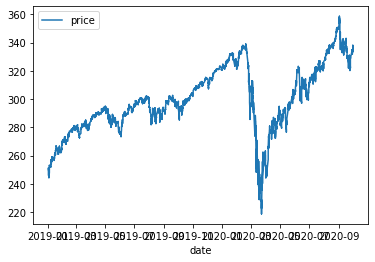

In [46]:
data_df.plot(x = 'date', y = 'price')

In [48]:
data_df.to_csv('../data/clean/prices_5_min/SPY.csv', index = False)